## this python script is used to extend the shoreline in the folder ECY_estimateed_shorelines

### shoreline in the folder ECY_estimateed_shorelines are missing some part of the shoreline, this script is used to extend the shoreline to the edge of the image

In [46]:
from shapely.geometry import Point, Polygon, LineString, MultiLineString,MultiPoint,MultiPolygon
from pyproj import Geod
import geojson
import copy
import pyproj

In [22]:
import numpy as np

In [23]:
import math

In [2]:
import geojson

### extend the 1701-1859 **coastside** shoreline to the south

In [25]:
#load 1700 geojson file
#import 1700 geojson file
with open('assets/shore_1700.geojson') as f:
    gj_1700 = geojson.load(f)
#print(gj)

In [26]:
#load 1860 geojson file
#import 1860 geojson file
with open('assets/shore_1860.geojson') as f:
    gj_1860 = geojson.load(f)
#print(gj)

In [195]:
geod = Geod(ellps='WGS84')   #the projection system is WGS84
f_azimuth, b_azimuth,_ = geod.inv(-124, 45, -124, 46)

In [122]:
#function to get the distance between two points，the result is in km
#lon1, lat1, lon2, lat2 in utm format

def haversine_distance(lon1, lat1, lon2, lat2):
    
    #x_1,y_1=convert_line_cooridination_system_to_wgs([[lon1, lat1],[lon2, lat2]])

    #lon1=x_1[0]
    #lon2=y_1[0]
    #lat1=x_1[1]
    #lat2=y_1[1]

    # Earth's radius in kilometers
    R = 6371

    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Difference in latitudes and longitudes
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = math.sin(delta_lat/2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon/2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c

    return distance


# Example usage
lat1 = 52.5200  # Latitude of first point
lon1 = 13.4050  # Longitude of first point
lat2 = 48.8566  # Latitude of second point
lon2 = 2.3522   # Longitude of second point

result = haversine_distance(lon1, lat1, lon2, lat2)
print(result)


877.4633259175432


In [108]:
#get the list of transect lines
#each transect line is a list of two points, the right point is each point in the 1700 shoreline, and then extend the line horizontally to the left

#empty list to store the x_values
x_values = []

#get the number of points in gj_1700
for i in range(len(gj_1700["features"][0]["geometry"]["coordinates"][0])):
    
    #x_value is the latitude of the horizontal transect lines
    x_values.append(gj_1700["features"][0]["geometry"]["coordinates"][0][i][1])

    #y_value is the longitude of the left end of transect lines
    y_value=-124.140016

    #zip the x and y values together
    points = zip([y_value]*len(x_values),x_values)
    points = list(points)
    #change the points to a list of lists
    points_left = [[point[0],point[1]] for point in points]

points_right = gj_1700["features"][0]["geometry"]["coordinates"][0]

line=list(zip(points_left,points_right))

#list of transects lines
list_of_transects=[list(t) for t in line]


In [109]:
list_of_transects

[[[-124.140016, 46.881191], [-124.11697, 46.881191]],
 [[-124.140016, 46.858835], [-124.110708, 46.858835]],
 [[-124.140016, 46.823382], [-124.097339, 46.823382]],
 [[-124.140016, 46.794212], [-124.090194, 46.794212]],
 [[-124.140016, 46.768967], [-124.085611, 46.768967]],
 [[-124.140016, 46.745573], [-124.085233, 46.745573]],
 [[-124.140016, 46.737395], [-124.079244, 46.737395]]]

In [56]:
list_of_transects[-1]

[[-124.140016, 46.737395], [-124.079244, 46.737395]]

In [74]:
#determine which line in the list of lines is the northernmost line
#the northernmost line is the line we use to find the intersection point between the two shorelines and the transect line. The bounded length is the length we want to offset the 1700 line
if list_of_transects[0][0][1] > list_of_transects[-1][0][1]:
    northmost_line = list_of_transects[0]
else:
    northmost_line = list_of_transects[-1]

northmost_line = [[-124.140016, 46.88], [-124.11697, 46.88]]
northmost_line


[[-124.140016, 46.88], [-124.11697, 46.88]]

In [128]:
#this is the funtion to offset the point, with given distance and bearing

from geographiclib.geodesic import Geodesic

import math

#point in the format of [lon,lat]   d in meters, bearing in degrees
def offset_pt(point,d,bearing):
    # Define the point's coordinates (longitude, latitude)
    lon1, lat1 = point[0], point[1]

    # Define the distance to move the point (in meters) and the bearing (in degrees)
    distance = d  # in meters
    bearing = bearing  # 50 degrees

    # Calculate destination point
    geod = Geodesic.WGS84  # define the WGS84 ellipsoid

    dest = geod.Direct(lat1, lon1, bearing, distance)

    lon2, lat2 = dest['lon2'], dest['lat2']

    return [lon2,lat2]


In [112]:
with open('assets/shore_1700.geojson') as f:
    gj_1700 = geojson.load(f)
gj_1700

{"features": [{"geometry": {"coordinates": [[[-124.11697, 46.881191], [-124.110708, 46.858835], [-124.097339, 46.823382], [-124.090194, 46.794212], [-124.085611, 46.768967], [-124.085233, 46.745573], [-124.079244, 46.737395]]], "type": "MultiLineString"}, "properties": {}, "type": "Feature"}], "type": "FeatureCollection"}

In [126]:

#first we need the transect line
transect=LineString([[-125, 46.88], [-124, 46.88]])

#then we need the shoreline of 1700 and find the intersection point with the transect line
with open('assets/shore_1700.geojson') as f:
    gj_1700 = geojson.load(f)

#get the linestring of the gj_1700
shoreline_1700 = LineString(gj_1700['features'][0]['geometry']['coordinates'][0])

#find the intersection point
insct_pt_1700 = transect.intersection(shoreline_1700)

print("intersection between transects and 1701 sholine is: ", insct_pt_1700)

print(insct_pt_1700.x,insct_pt_1700.y)
print("shoreline_1700: ", shoreline_1700)

intersection between transects and 1701 sholine is:  POINT (-124.11663639640365 46.88)
-124.11663639640365 46.88
shoreline_1700:  LINESTRING (-124.11697 46.881191, -124.110708 46.858835, -124.097339 46.823382, -124.090194 46.794212, -124.085611 46.768967, -124.085233 46.745573, -124.079244 46.737395)


In [200]:
#get the distance to move in each year

#create a empty list to store the distance to move in each year
distance_to_move_since1700 = []
for i in range(1701,1860):
    with open('assets/ECY_estimated_shorelines/'+str(i)+'.geojson') as f:
        gj = geojson.load(f)
    
    #first we need to find the intersection point between the northernmost transcets line and the shoreline of the year in the loop
    shoreline_current = LineString(gj['geometry']["coordinates"])
    insct_pt_current = transect.intersection(shoreline_current)

    #second we need to measure the distance to move
    #the distance is in kilometer (km)
    distance= haversine_distance(insct_pt_1700.x,insct_pt_1700.y,insct_pt_current.x,insct_pt_current.y)

    #append the distance to the list
    distance_to_move_since1700.append(distance)

print(distance_to_move_since1700)


[0.0009292933972156338, 0.001884235128703863, 0.00282438501809143, 0.003779417219461357, 0.004675775586219875, 0.0056163629726466375, 0.006571715869160812, 0.0075199594470059744, 0.008424497920578578, 0.009365617998449385, 0.010321291592041598, 0.011269481830928242, 0.012161123605393025, 0.013117117896063261, 0.014073112184799515, 0.015007138809735076, 0.015914547677739786, 0.016870862663553993, 0.01780504963606143, 0.01876136461994151, 0.019670216621897017, 0.020612998648957215, 0.021561199622934228, 0.02251783530195814, 0.023428130435930446, 0.024362638103581337, 0.02531959447968304, 0.02627655085771849, 0.027174809726311023, 0.02812295713699602, 0.029080234208241386, 0.03002427088146726, 0.03093745465043708, 0.03188552104028606, 0.0328300251976391, 0.03378771924141804, 0.034692411349984534, 0.03563738638159536, 0.036595401799317674, 0.03755341721897365, 0.03845914429981464, 0.03940469122693541, 0.04036302801860078, 0.04132136481219981, 0.042215587524271105, 0.04317424568987973, 0.04

In [133]:

#an empty dictionary to store the extended lines of each year between 1701 and 1859
extended_lines={}

for i in range(1701,1860):
    
    with open('assets/ECY_estimated_shorelines/'+str(i)+'.geojson') as f:
        gj = geojson.load(f)
    
    #first we need to find the intersection point between the northernmost transcets line and the shoreline of the year in the loop
    shoreline_current = LineString(gj['geometry']["coordinates"])
    insct_pt_current = transect.intersection(shoreline_current)

    #second we need to measure the distance to move
    #the distance is in kilometer (km)
    distance= haversine_distance(insct_pt_1700.x,insct_pt_1700.y,insct_pt_current.x,insct_pt_current.y)

    #third we need to move the points on 1700 line to the wast to the new location by the distance we just calculated
       
        
    list_of_pts=[]
    for point in gj_1700['features'][0]['geometry']['coordinates'][0]:
        new_point = offset_pt(point,distance*1000,270)                   #offest all points on the 1700 shoreline to the east by the distance we just calculated.
        list_of_pts.append(new_point)


    #finally, after all points have been offset, we need to put them in a dictionary
    extended_lines[str(i)]=list_of_pts

print(extended_lines)



{'1701': [[-124.11698219154297, 46.88119099999935], [-124.1107201864819, 46.85883499999935], [-124.09735117846829, 46.823381999999356], [-124.09020617188627, 46.794211999999355], [-124.0856231661982, 46.76896699999936], [-124.08524516093406, 46.745572999999354], [-124.0792561590954, 46.73739499999935]], '1702': [[-124.1169947195704, 46.88119099999733], [-124.11073270930856, 46.85883499999734], [-124.09736369306016, 46.82338199999734], [-124.09021867971445, 46.79421199999734], [-124.08563566818133, 46.76896699999734], [-124.08525765750775, 46.74557299999734], [-124.07926865377968, 46.73739499999735]], '1703': [[-124.11700705354137, 46.881190999994004], [-124.11074503815934, 46.85883499999401], [-124.0973760138037, 46.82338199999402], [-124.09023099379907, 46.794211999994026], [-124.08564797651142, 46.76896699999403], [-124.0852699605122, 46.74557299999403], [-124.07928095492399, 46.73739499999403]], '1704': [[-124.11701958275569, 46.881190999989265], [-124.11075756217238, 46.85883499998

In [134]:
len(extended_lines)

159

In [135]:
#test cell
# the line is extended from north to south, decreasing lat
extended_lines['1701']

[[-124.11698219154297, 46.88119099999935],
 [-124.1107201864819, 46.85883499999935],
 [-124.09735117846829, 46.823381999999356],
 [-124.09020617188627, 46.794211999999355],
 [-124.0856231661982, 46.76896699999936],
 [-124.08524516093406, 46.745572999999354],
 [-124.0792561590954, 46.73739499999935]]

In [138]:
#test cell
extended_lines['1701']

[[-124.11698219154297, 46.88119099999935],
 [-124.1107201864819, 46.85883499999935],
 [-124.09735117846829, 46.823381999999356],
 [-124.09020617188627, 46.794211999999355],
 [-124.0856231661982, 46.76896699999936],
 [-124.08524516093406, 46.745572999999354],
 [-124.0792561590954, 46.73739499999935]]

In [140]:
#find if the extended_lines extend from the north to the south
i=0
for key in extended_lines.keys():
    if extended_lines[key][0][1] > extended_lines[key][1][1]:
        i=i+1

if i == len(extended_lines):
    print("all extended lines extend from north to south")

all extended lines extend from north to south


In [153]:
#find if the original shorelins extend from the north to the south
k=0
for i in range(1701,1860):
    with open('assets/ECY_estimated_shorelines/'+str(i)+'.geojson') as f:
        gj = geojson.load(f)
    shoreline_current = gj['geometry']["coordinates"]
    if shoreline_current[0][1]<shoreline_current[1][1]:
        k=k+1
if k==len(extended_lines):
    print("all original shorelines extend from south to north")

all original shorelines extend from south to north


In [159]:
#for the extended lines, if the point is north of the southmost point of the original line, remove it. Because it should be south of the southmost point
for i in range(1701,1860):

    with open('assets/ECY_estimated_shorelines/'+str(i)+'.geojson') as f:
        gj = geojson.load(f)
    #first find the southmost point of the original line
    ##because the original line is a list of points from south to north, the southmost point is the first point
    southmost_pt = gj['geometry']['coordinates'][0]
    for pt in extended_lines[str(i)]:
        #remove the point if this point is north of the southmost point
        if pt[1] > southmost_pt[1]:
            extended_lines[str(i)].remove(pt)
        else:
            break
    #insert the southmost point to the beginning of the extended line
    extended_lines[str(i)].insert(0,southmost_pt)


    

In [234]:
#write the template for feature collection

outer_template={"type": "FeatureCollection","features":[]}

#write the template for feature

feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}



In [148]:
import json

{"geometry": {"coordinates": [[-124.110784, 46.859099], [-124.115942, 46.877483], [-124.116075, 46.877957], [-124.116208, 46.878432], [-124.116342, 46.878907], [-124.116475, 46.879381], [-124.116608, 46.879856], [-124.116742, 46.880331], [-124.116875, 46.880805]], "type": "LineString"}, "properties": {}, "type": "Feature"}

In [247]:
#rewrite the shoreline geojson file from 1701 to 1859
for i in range(1701,1860):
    # insert the original shoreline as layer one
    with open('assets/ECY_estimated_shorelines/'+str(i)+'.geojson') as f:
        gj = geojson.load(f)
    #first we need to amend gj to make it conform to our desired structure
    gj['properties']['layer']='layer1'
    outer_template={"type": "FeatureCollection","features":[]}

    feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}
    tmp_outer=outer_template.copy()
    if i == 1701:
        print(tmp_outer)
    tmp_outer['features'].append(gj)


    #then we need to insert the extended line as layer two
    tmp_inner=feature_template.copy()
    tmp_inner['properties']['layer']='layer2'
    tmp_inner['geometry']["coordinates"]=extended_lines[str(i)]
    tmp_outer['features'].append(tmp_inner)

    """tmp=feature_template.copy()
    tmp['properties']['layer']='layer1'
    tmp['geometry']["coordinates"]=gj['geometry']['coordinates']
    tmp1=feature_template.copy()
    tmp1['properties']['layer']='layer2'
    tmp1['geometry']["coordinates"]=extended_lines[str(i)]

    #insert tmp and tmp1 to the outer_template
    outer_tmp_copy=outer_template.copy()
    outer_tmp_copy['features'].append(tmp)
    outer_tmp_copy['features'].append(tmp1)"""

    #print(outer_tmp_copy)

    #write the outer_tmp_copy to a new geojson file
    with open('assets/ECY_estimated_shorelines/'+str(i)+'_Jun23.geojson', 'w') as f:
        json.dump(tmp_outer, f)


{'type': 'FeatureCollection', 'features': []}


In [240]:
with open('assets/ECY_estimated_shorelines/1701.geojson') as f:
    gj_1701 = geojson.load(f)
gj_1701
#gj_1701["geometry"]["coordinates"]

{"geometry": {"coordinates": [[-124.110784, 46.859099], [-124.115942, 46.877483], [-124.116075, 46.877957], [-124.116208, 46.878432], [-124.116342, 46.878907], [-124.116475, 46.879381], [-124.116608, 46.879856], [-124.116742, 46.880331], [-124.116875, 46.880805]], "type": "LineString"}, "properties": {}, "type": "Feature"}

In [243]:
extended_lines['1701']

[[-124.110784, 46.859099],
 [-124.1107201864819, 46.85883499999935],
 [-124.09735117846829, 46.823381999999356],
 [-124.09020617188627, 46.794211999999355],
 [-124.0856231661982, 46.76896699999936],
 [-124.08524516093406, 46.745572999999354],
 [-124.0792561590954, 46.73739499999935]]

## extend the 1701-1859 **oceanside** shoreline to the north, which is curved.

### this time, we do not start from the 1700. Instead, we start from the 1860, and offest the 1860 shoreline towards the land.

In [173]:
#preview of the 1860 geojson file
if len(gj_1860["features"])==1:
    print("the 1860 geojson file has only one feature")

the 1860 geojson file has only one feature


In [176]:
print("The 1860 original file is multiLineString, with {} lineString".format(len(gj_1860["features"][0]["geometry"]["coordinates"])))

The 1860 original file is multiLineString, with 2 lineString


In [ ]:
#a dictionary to store the extended curves between 1701 and 1859
extended_curves={}

In [182]:
#test cell
print(transect)

LINESTRING (-125 46.88, -124 46.88)


In [180]:
#test cell
gj_1860["features"][0]["geometry"]["coordinates"][0]

[[-124.117626, 46.877113],
 [-124.117716, 46.877859],
 [-124.118055, 46.878537],
 [-124.118327, 46.879171],
 [-124.11853, 46.879736],
 [-124.118847, 46.880573],
 [-124.119186, 46.88141],
 [-124.119503, 46.88245],
 [-124.119684, 46.883332],
 [-124.119548, 46.884304],
 [-124.119706, 46.885051],
 [-124.119661, 46.886001],
 [-124.119751, 46.887018],
 [-124.119706, 46.887606],
 [-124.11939, 46.888262],
 [-124.119186, 46.889167],
 [-124.119209, 46.889687],
 [-124.118847, 46.890162],
 [-124.118824, 46.891225],
 [-124.118508, 46.891926],
 [-124.118168, 46.892944],
 [-124.117874, 46.894391],
 [-124.117445, 46.895409],
 [-124.116902, 46.897127],
 [-124.116088, 46.898303],
 [-124.115839, 46.899095],
 [-124.115126, 46.900499],
 [-124.114172, 46.9017],
 [-124.112971, 46.902937],
 [-124.111628, 46.903997],
 [-124.109897, 46.90488],
 [-124.108492, 46.905178],
 [-124.107246, 46.905552],
 [-124.106222, 46.905799],
 [-124.104843, 46.906046],
 [-124.103783, 46.906011],
 [-124.102653, 46.905834],
 [-124.1

In [183]:
#the distance between 1860 shoreline and 1700 shoreline on transect

#first we need to find the intersection point between transect and the 1860 shoreline
insct_pt_1860 = transect.intersection(MultiLineString(gj_1860["features"][0]["geometry"]["coordinates"]))

print(insct_pt_1860)
#get the first point of the insct_pt_1860 multipoint

print(insct_pt_1860.geoms[0].x)
#get the distance  to move between 
distance_1860_1700=haversine_distance(insct_pt_1700.x,insct_pt_1700.y,insct_pt_1860.geoms[0].x,insct_pt_1860.geoms[0].y)
distance_1860_1700

In [204]:
#distance_to_move_since1700.append(distance_1860_1700)
distance_from_1860_back=list(reversed(distance_to_move_since1700))
distance_from_1860_back=[distance_1860_1700- i for i in distance_from_1860_back]

distance_from_1860_back.append(distance_1860_1700)   #the distance to move from 1860 to 1700 is the distance between 1860 and 1700

In [206]:
distance_from_1860_back

[0.0009503492279573644,
 0.001918804157509224,
 0.0028872590870621107,
 0.003817306416002919,
 0.004785437231274198,
 0.005753568044612495,
 0.006693662931816169,
 0.007650449729762282,
 0.008618256428819915,
 0.009581674477061541,
 0.010525995957943984,
 0.011481324239684065,
 0.012448806824461867,
 0.013388577595454337,
 0.014356060180233943,
 0.015309929945767853,
 0.01627204739639701,
 0.017216697130119973,
 0.018183855600619553,
 0.019130964124754846,
 0.02009768193628675,
 0.021042547860946947,
 0.022003788134127067,
 0.022954658111702775,
 0.023899619547930323,
 0.024866129787934926,
 0.025826673558483088,
 0.026776088125699316,
 0.027721256787293064,
 0.028681224048041964,
 0.029647295007953503,
 0.030595254160942345,
 0.03153415740853635,
 0.03249990494456978,
 0.03346565248253794,
 0.034385473645767675,
 0.0353508977559891,
 0.03631632186814519,
 0.037274721265989574,
 0.038200273442211274,
 0.0391653741266214,
 0.040130474814899994,
 0.0410881992093034,
 0.04201280926183408,

In [266]:
#a dictionary to store the extended curves between 1701 and 1859
extended_curves={}

for i in range(1859,1699,-1):
    #a list to store the offset points of the year
    offset_points=[]
    for linestring in gj_1860["features"][0]["geometry"]["coordinates"]:    #add [0] to exclude grass island
        offset_points_linestring=[]
        #each j associated with a point in the line
        for j in range(0,len(linestring)-4,3):       #set the step to 3 to make the line lower in resolution
            #get the azimuth of the line
            geo=Geod(ellps='WGS84')
            f_azimuth, b_azimuth,_ = geo.inv(linestring[j][0], linestring[j][1], linestring[j+3][0], linestring[j+3][1])
            azimuth=90+f_azimuth
            if azimuth>360:
                azimuth=azimuth-360
            point=offset_pt(linestring[j],distance_from_1860_back[1859-i]*1000,azimuth)    #offset_pt(point,d,bearing)
            offset_points_linestring.append(point)
        offset_points.append(offset_points_linestring)
    extended_curves[str(i)]=offset_points


In [261]:
distance_from_1860_back

[0.0009503492279573644,
 0.001918804157509224,
 0.0028872590870621107,
 0.003817306416002919,
 0.004785437231274198,
 0.005753568044612495,
 0.006693662931816169,
 0.007650449729762282,
 0.008618256428819915,
 0.009581674477061541,
 0.010525995957943984,
 0.011481324239684065,
 0.012448806824461867,
 0.013388577595454337,
 0.014356060180233943,
 0.015309929945767853,
 0.01627204739639701,
 0.017216697130119973,
 0.018183855600619553,
 0.019130964124754846,
 0.02009768193628675,
 0.021042547860946947,
 0.022003788134127067,
 0.022954658111702775,
 0.023899619547930323,
 0.024866129787934926,
 0.025826673558483088,
 0.026776088125699316,
 0.027721256787293064,
 0.028681224048041964,
 0.029647295007953503,
 0.030595254160942345,
 0.03153415740853635,
 0.03249990494456978,
 0.03346565248253794,
 0.034385473645767675,
 0.0353508977559891,
 0.03631632186814519,
 0.037274721265989574,
 0.038200273442211274,
 0.0391653741266214,
 0.040130474814899994,
 0.0410881992093034,
 0.04201280926183408,

In [267]:
#preview the extended curves
extended_curves["1700"]

[[[-124.11569038493373, 46.87742298464],
  [-124.11640461461738, 46.879517733102674],
  [-124.11720541006453, 46.88152644942142],
  [-124.11756264313156, 46.88437378611379],
  [-124.11779447313879, 46.88677620803188],
  [-124.11721216213697, 46.889003807875206],
  [-124.11687656187141, 46.890950375201],
  [-124.11597642286914, 46.89398392124848],
  [-124.11423330329947, 46.89781151945139],
  [-124.1127095214891, 46.90077644211054],
  [-124.10921529867203, 46.9035995862766],
  [-124.1061935012418, 46.904436146748246],
  [-124.1035844784563, 46.904629756394776],
  [-124.10099773781023, 46.90377465746693],
  [-124.09885119097315, 46.902242584310244],
  [-124.09771518182815, 46.902973627954765],
  [-124.09580232207647, 46.90274289491592],
  [-124.09652198070991, 46.90306188799393],
  [-124.0976827068335, 46.903736927403784],
  [-124.09852029507063, 46.90417388977985],
  [-124.09999378998666, 46.90508229166236],
  [-124.10174659825388, 46.906057717616385],
  [-124.10433143995445, 46.9066169

In [268]:

#write the template for feature collection

outer_template={"type": "FeatureCollection","features":[]}

#write the template for feature

feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}



In [248]:
#test cell
with open('assets/ECY_estimated_shorelines/'+str(1701)+'_Jun23.geojson') as f:
    gj_1701_j = geojson.load(f)

In [249]:
gj_1701_j

{"features": [{"geometry": {"coordinates": [[-124.110784, 46.859099], [-124.115942, 46.877483], [-124.116075, 46.877957], [-124.116208, 46.878432], [-124.116342, 46.878907], [-124.116475, 46.879381], [-124.116608, 46.879856], [-124.116742, 46.880331], [-124.116875, 46.880805]], "type": "LineString"}, "properties": {"layer": "layer1"}, "type": "Feature"}, {"geometry": {"coordinates": [[-124.110784, 46.859099], [-124.11072, 46.858835], [-124.097351, 46.823382], [-124.090206, 46.794212], [-124.085623, 46.768967], [-124.085245, 46.745573], [-124.079256, 46.737395]], "type": "LineString"}, "properties": {"layer": "layer2"}, "type": "Feature"}], "type": "FeatureCollection"}

In [269]:
#test cell
extended_curves.keys()

dict_keys(['1859', '1858', '1857', '1856', '1855', '1854', '1853', '1852', '1851', '1850', '1849', '1848', '1847', '1846', '1845', '1844', '1843', '1842', '1841', '1840', '1839', '1838', '1837', '1836', '1835', '1834', '1833', '1832', '1831', '1830', '1829', '1828', '1827', '1826', '1825', '1824', '1823', '1822', '1821', '1820', '1819', '1818', '1817', '1816', '1815', '1814', '1813', '1812', '1811', '1810', '1809', '1808', '1807', '1806', '1805', '1804', '1803', '1802', '1801', '1800', '1799', '1798', '1797', '1796', '1795', '1794', '1793', '1792', '1791', '1790', '1789', '1788', '1787', '1786', '1785', '1784', '1783', '1782', '1781', '1780', '1779', '1778', '1777', '1776', '1775', '1774', '1773', '1772', '1771', '1770', '1769', '1768', '1767', '1766', '1765', '1764', '1763', '1762', '1761', '1760', '1759', '1758', '1757', '1756', '1755', '1754', '1753', '1752', '1751', '1750', '1749', '1748', '1747', '1746', '1745', '1744', '1743', '1742', '1741', '1740', '1739', '1738', '1737', '1736

In [270]:
#rewrite the shoreline geojson file from 1701 to 1859
for i in range(1701,1860):
    # insert the original shoreline as layer one
    with open('assets/ECY_estimated_shorelines/'+str(i)+'_Jun23.geojson') as f:
        gj = geojson.load(f)
    
    feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}
    tmp_inner=feature_template.copy()
    #if i == 1701:
    #    print(tmp_outer)
    #tmp_inner['features'].append(gj)
    tmp_inner['geometry']['type']='MultiLineString'
    tmp_inner['properties']['layer']='layer3'
    tmp_inner['geometry']["coordinates"]=extended_curves[str(i)]

    gj['features'].append(tmp_inner)


    #then we need to insert the extended line as layer two
    

    #print(outer_tmp_copy)

    #write the outer_tmp_copy to a new geojson file
    with open('assets/ECY_estimated_shorelines/'+str(i)+'_Jun27.geojson', 'w') as f:
        json.dump(gj, f)

{'type': 'FeatureCollection', 'features': [{"geometry": {"coordinates": [[-124.115423, 46.859099], [-124.11763, 46.87724], [-124.117689, 46.877725], [-124.117872, 46.878193], [-124.118094, 46.878655], [-124.118293, 46.87912], [-124.118465, 46.879589], [-124.118639, 46.880058], [-124.118816, 46.880526]], "type": "LineString"}, "properties": {"layer": "layer1"}, "type": "Feature"}, {'type': 'Feature', 'properties': {'layer': 'layer2'}, 'geometry': {'type': 'LineString', 'coordinates': [[-124.115423, 46.859099], [-124.11268256019359, 46.858834982970194], [-124.09931226175753, 46.82338198299116], [-124.09216619528102, 46.79421198300839], [-124.08758227365085, 46.768966983023276], [-124.08720342070846, 46.74557298303708], [-124.08121412279169, 46.73739498304189]]}}]}


In [271]:
#preview the 1701_jun27 geojson file
with open('assets/ECY_estimated_shorelines/'+str(1701)+'_Jun27.geojson') as f:
    gj_1701_jun27 = geojson.load(f)


In [277]:
extended_curves['1700']

[[[-124.11569038493373, 46.87742298464],
  [-124.11640461461738, 46.879517733102674],
  [-124.11720541006453, 46.88152644942142],
  [-124.11756264313156, 46.88437378611379],
  [-124.11779447313879, 46.88677620803188],
  [-124.11721216213697, 46.889003807875206],
  [-124.11687656187141, 46.890950375201],
  [-124.11597642286914, 46.89398392124848],
  [-124.11423330329947, 46.89781151945139],
  [-124.1127095214891, 46.90077644211054],
  [-124.10921529867203, 46.9035995862766],
  [-124.1061935012418, 46.904436146748246],
  [-124.1035844784563, 46.904629756394776],
  [-124.10099773781023, 46.90377465746693],
  [-124.09885119097315, 46.902242584310244],
  [-124.09771518182815, 46.902973627954765],
  [-124.09580232207647, 46.90274289491592],
  [-124.09652198070991, 46.90306188799393],
  [-124.0976827068335, 46.903736927403784],
  [-124.09852029507063, 46.90417388977985],
  [-124.09999378998666, 46.90508229166236],
  [-124.10174659825388, 46.906057717616385],
  [-124.10433143995445, 46.9066169

In [276]:
gj_1700

{"features": [{"geometry": {"coordinates": [[[-124.11697, 46.881191], [-124.110708, 46.858835], [-124.097339, 46.823382], [-124.090194, 46.794212], [-124.085611, 46.768967], [-124.085233, 46.745573], [-124.079244, 46.737395]]], "type": "MultiLineString"}, "properties": {}, "type": "Feature"}], "type": "FeatureCollection"}

In [278]:
#rewrite the shoreline geojson file of 1700
with open('assets/shore_1700.geojson') as f:
    gj_1700 = geojson.load(f)
gj_1700["features"][0]["properties"]["layer"]="layer1"

feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}
tmp_inner=feature_template.copy()
tmp_inner['geometry']['type']='MultiLineString'
tmp_inner['properties']['layer']='layer3'
tmp_inner['geometry']["coordinates"]=extended_curves["1700"]

gj_1700['features'].append(tmp_inner)


#then we need to insert the extended line as layer two


#print(outer_tmp_copy)

#write the outer_tmp_copy to a new geojson file
with open('assets/ECY_estimated_shorelines/1700_Jun27.geojson', 'w') as f:
    json.dump(gj_1700, f)

In [281]:
#rewrite the shoreline geojson file of 1860
with open('assets/shore_1700.geojson') as f:
    gj_1700 = geojson.load(f)

#empty list to store the offset points
offset_points_1700_1860=[]
for point in gj_1700['features'][0]['geometry']['coordinates'][0]:
    n_point=offset_pt(point,distance_1860_1700*1000,270)   #offset_pt(point,d,bearing)

    offset_points_1700_1860.append(n_point)

In [282]:
offset_points_1700_1860

[[-124.1189578480116, 46.88119098274114],
 [-124.11269502279549, 46.858834982754544],
 [-124.09932471616425, 46.82338198277578],
 [-124.09217864295658, 46.79421198279322],
 [-124.08759471550947, 46.7689669828083],
 [-124.08721585718365, 46.74557298282227],
 [-124.08122655738657, 46.73739498282715]]

In [284]:
#remove the first point of the offset_points_1700_1860
offset_points_1700_1860.pop(0)
offset_points_1700_1860

[[-124.11269502279549, 46.858834982754544],
 [-124.09932471616425, 46.82338198277578],
 [-124.09217864295658, 46.79421198279322],
 [-124.08759471550947, 46.7689669828083],
 [-124.08721585718365, 46.74557298282227],
 [-124.08122655738657, 46.73739498282715]]

In [285]:
offset_points_1700_1860.insert(0,[-124.117626, 46.877113])
offset_points_1700_1860

[[-124.117626, 46.877113],
 [-124.11269502279549, 46.858834982754544],
 [-124.09932471616425, 46.82338198277578],
 [-124.09217864295658, 46.79421198279322],
 [-124.08759471550947, 46.7689669828083],
 [-124.08721585718365, 46.74557298282227],
 [-124.08122655738657, 46.73739498282715]]

In [286]:
with open('assets/shore_1860.geojson') as f:
    gj_1860 = geojson.load(f)

#layer 1 is the original shoreline
gj_1860["features"][0]["properties"]["layer"]="layer1"

feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}

tmp_inner=feature_template.copy()

#tmp_inner['geometry']['type']='MultiLineString'

tmp_inner['properties']['layer']='layer2'

tmp_inner['geometry']["coordinates"] = offset_points_1700_1860

gj_1860['features'].append(tmp_inner)


#then we need to insert the extended line as layer two


#print(outer_tmp_copy)

#write the outer_tmp_copy to a new geojson file
with open('assets/ECY_estimated_shorelines/1860_Jun27.geojson', 'w') as f:
    json.dump(gj_1860, f)



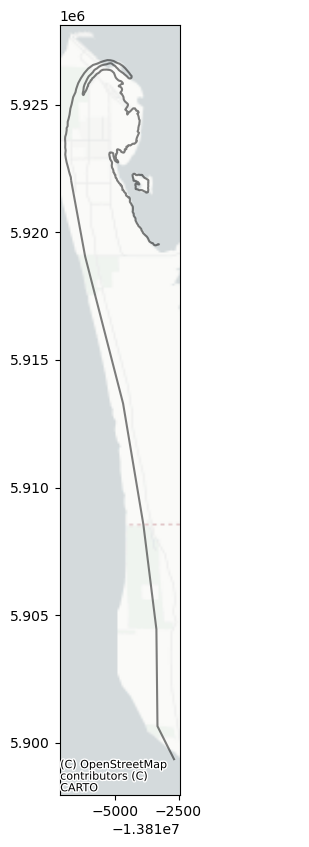

In [287]:
#preview of the 1801_jul23 geojson file
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Load a GeoDataFrame from a GeoJSON file
#gdf = gpd.read_file('assets/ECY_estimated_shorelines/1801_Jul23.geojson')
#load 1860 shoreline
gdf = gpd.read_file('assets/ECY_estimated_shorelines/'+str(1860)+'_Jun27.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

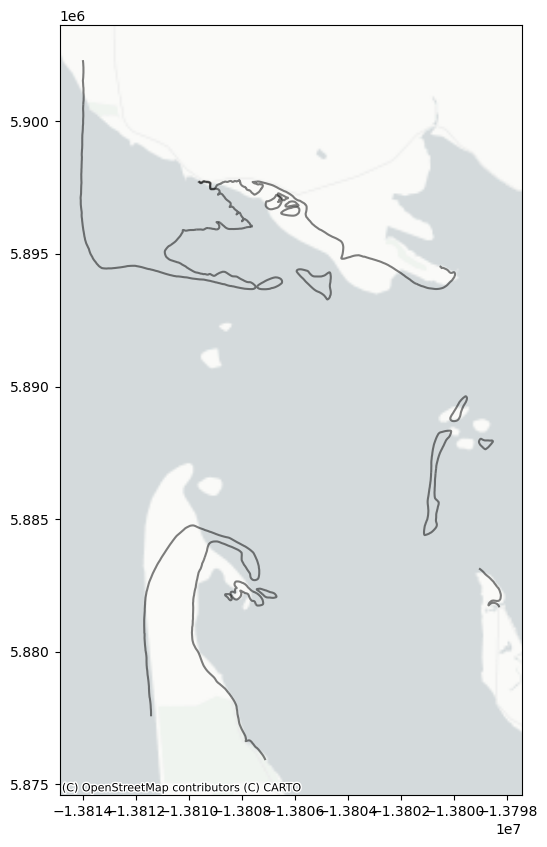

In [289]:
gdf = gpd.read_file('assets/f_1911_coastline_bay.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

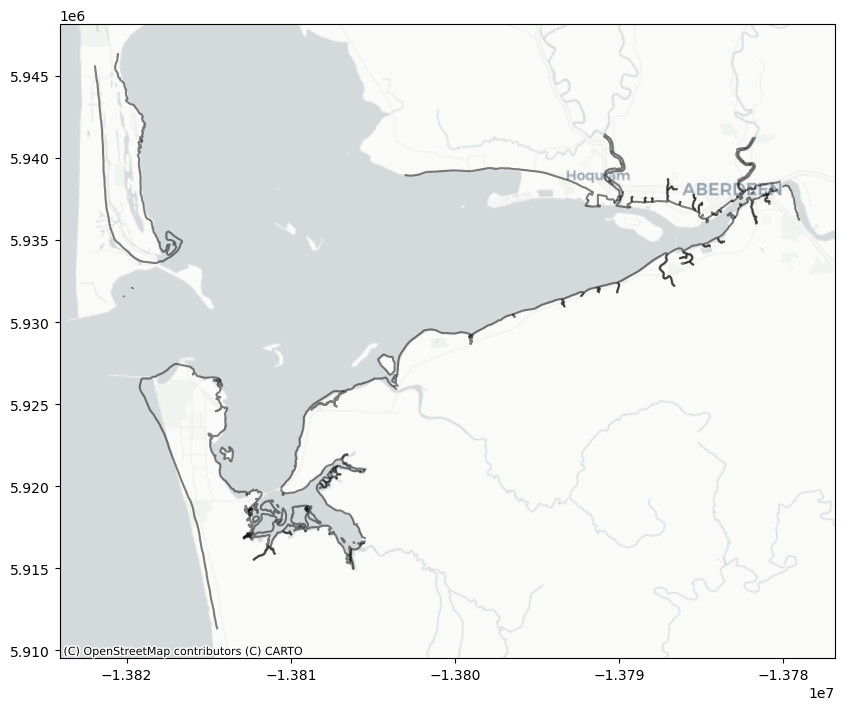

In [293]:
gdf = gpd.read_file('assets/shore_1911.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

Moved point is at Longitude: -124.11069866461231 and Latitude: 46.8588403732888


In [91]:
l_3=LineString([[-124.116608, 46.879856],[-124.116742, 46.880331]])
print(transect.intersection(l_3))#function to convert cooridination system from EPSG: 32149 to WGS84
##point = [lon,lat]
def convert_line_cooridination_system_to_wgs(line):
    # Define the source and target coordinate systems
    src_crs = pyproj.CRS.from_epsg(32149)
    tgt_crs = pyproj.CRS.from_epsg(4326)

    # Create a transformer object
    transformer = pyproj.Transformer.from_crs(src_crs, tgt_crs, always_xy=True)

    #an empty list to store the converted points
    converted_points = []
    
    #iterate over every point in the line
    for i in range(len(line)):
        # Convert a single point
        x_1, y_1 = transformer.transform(line[i][0], line[i][1])
        converted_points.append([x_1,y_1])

    return converted_points


POINT (-124.1166486231579 46.88)


### Now plot the line from 1860 to 1911

In [294]:
#import two 1911 shoreline files
with open('assets/f_1911_coastline_bay.geojson') as f:
    gj_1911_bay = geojson.load(f)
#gj_1911_bay["features"]

#find the northernmost point of the 1911 shoreline

#a temporary variable to store the altitude of the northernmost point
tmp_altitude=0

for feature in gj_1911_bay["features"]:
    for linestring in feature["geometry"]["coordinates"]:
        #the northmost point is either the first or the last point of the linestring
        alt_1=linestring[0]
        alt_2=linestring[-1]
        if alt_1[1]>alt_2[1]:
            t=alt_1
        else:
            t=alt_2
        if t[1]>tmp_altitude:
            tmp_altitude=t[1]
            northmost_point=t

print(northmost_point)

[-124.093264, 46.7558]


In [295]:
print("the northmost point of the 1911 bay shoreline is: "+str(northmost_point))

the northmost point of the 1911 bay shoreline is: [-124.093264, 46.7558]


In [297]:
#then find the southernmost point of the 1911 shoreline on the north side of the willapa bay
with open('assets/shore_1911.geojson') as f:
    gj_1911 = geojson.load(f)

tmp_altitude=90

for feature in gj_1911["features"]:
    for linestring in feature["geometry"]["coordinates"]:
        #the northmost point is either the first or the last point of the linestring
        alt_1=linestring[0]
        alt_2=linestring[-1]
        if alt_1[1]<alt_2[1]:
            t=alt_1
        else:
            t=alt_2
        if t[1]<tmp_altitude:
            tmp_altitude=t[1]
            southmost_point=t

print(southmost_point)

[-124.097544, 46.811028]


In [298]:
print("the southmost point of the 1911 bay shoreline is: "+str(southmost_point))

the southmost point of the 1911 bay shoreline is: [-124.097544, 46.811028]


In [301]:
len(gj_1911_bay["features"])

62

In [302]:
[1,2]+[3,4]

[1, 2, 3, 4]

In [303]:
#append gj_1911_bay to gj_1911
gj_1911["features"]=gj_1911["features"]+gj_1911_bay["features"]

In [320]:
#add the layer type to each feature in gj_1911
for feature in gj_1911["features"]:
    feature["properties"]["layer"]="layer1"

In [321]:
#connect southmost point and northmost point and append it to gj_1911
gj_1911["features"].append({"type": "Feature","properties":{'layer':'layer2'},"geometry":{"coordinates":[southmost_point,northmost_point],"type": "LineString"}})

In [322]:
#write the gj_1911 to a new geojson file
with open('assets/ECY_estimated_shorelines/1911_Jun28.geojson', 'w') as f:
    json.dump(gj_1911, f)


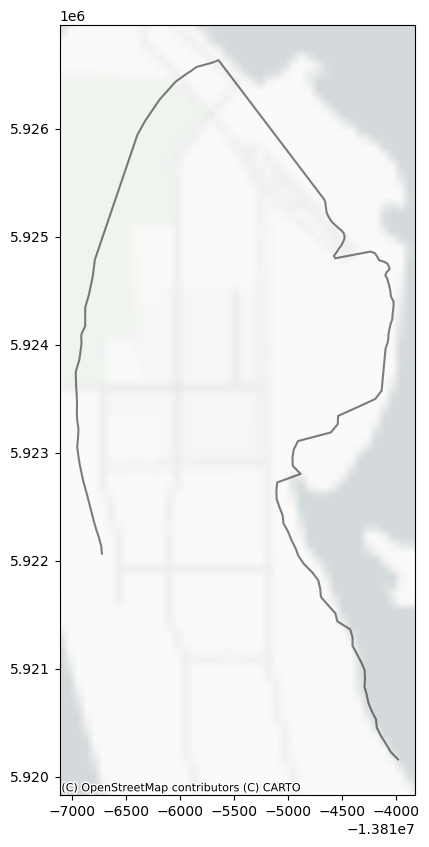

In [325]:
gdf = gpd.read_file('assets/ECY_estimated_shorelines/1861.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

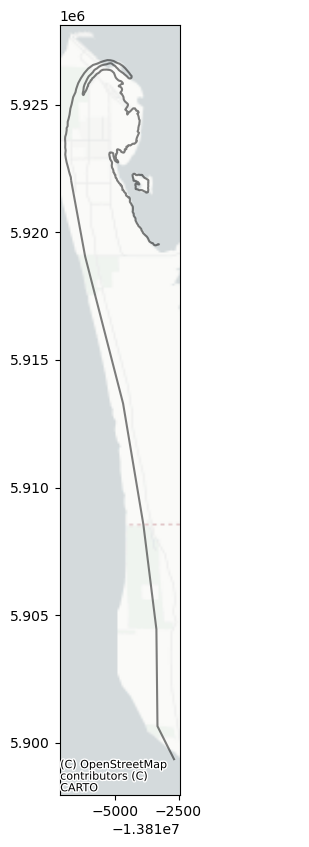

In [324]:
gdf = gpd.read_file('assets/ECY_estimated_shorelines/1860_Jun27.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

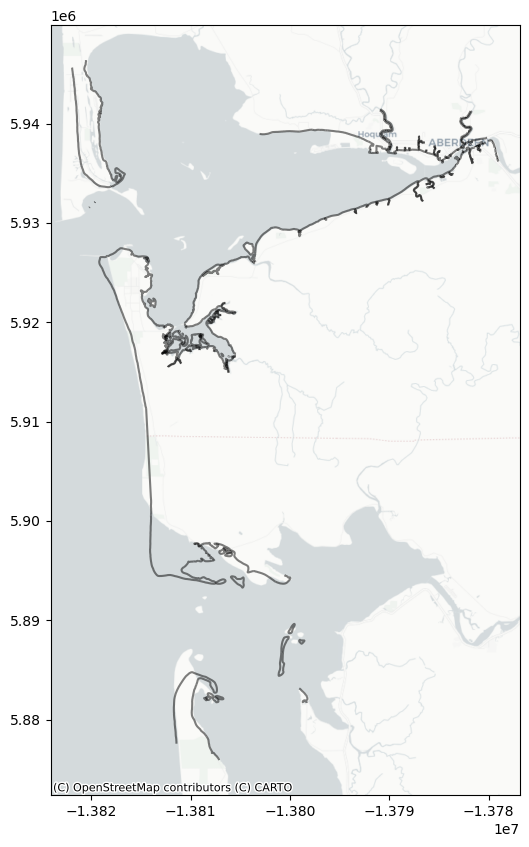

In [323]:
gdf = gpd.read_file('assets/ECY_estimated_shorelines/1911_Jun28.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

In [326]:
#preview list of transects
list_of_transects

[[[-124.140016, 46.881191], [-124.11697, 46.881191]],
 [[-124.140016, 46.858835], [-124.110708, 46.858835]],
 [[-124.140016, 46.823382], [-124.097339, 46.823382]],
 [[-124.140016, 46.794212], [-124.090194, 46.794212]],
 [[-124.140016, 46.768967], [-124.085611, 46.768967]],
 [[-124.140016, 46.745573], [-124.085233, 46.745573]],
 [[-124.140016, 46.737395], [-124.079244, 46.737395]]]

In [327]:
#convert each transect to line string object
list_of_transects_str=[]
for i in range(len(list_of_transects)):
    list_of_transects_str.append(LineString(list_of_transects[i]))

In [328]:
#preview list of transects in string format
list_of_transects_str

[<LINESTRING (-124.14 46.881, -124.117 46.881)>,
 <LINESTRING (-124.14 46.859, -124.111 46.859)>,
 <LINESTRING (-124.14 46.823, -124.097 46.823)>,
 <LINESTRING (-124.14 46.794, -124.09 46.794)>,
 <LINESTRING (-124.14 46.769, -124.086 46.769)>,
 <LINESTRING (-124.14 46.746, -124.085 46.746)>,
 <LINESTRING (-124.14 46.737, -124.079 46.737)>]

In [ ]:
for year in range(1861,1911):
    with open('assets/ECY_estimated_shorelines/'+str(year)+'.geojson') as f:
        gj = geojson.load(f)
    tmp_bin=[]
    for transect in list_of_transects:
        insct_1911=transect.intersection(gdf_1911)